In [14]:
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import os

In [2]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

c:\Users\neals\anaconda3\envs\clip\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\neals\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [10]:
# Load your CSV
# Tokens too big in opoen ai
'''
plane_df = pd.read_csv('openai_results_plane.csv', index_col=0)
plane_df.rename(columns={'img_id': 'image_id'}, inplace=True)
ship_df = pd.read_csv('openai_results_ship.csv')
ship_df.rename(columns={'img_id': 'image_id'}, inplace=True)
plane_context = plane_df[plane_df['prompt']=='Describe every item in the image']
ship_context = ship_df[ship_df['prompt']=='Describe every item in the image']
context_df = pd.concat([plane_context,ship_context])
print(context_df.columns)
print(context_df['prompt'].unique())
context_df.head()
'''
prompt_results_df = pd.read_csv('C:/Users/neals/Desktop/practicum/prompt_results_classification.csv')
prompt_results_df['prompt'] = prompt_results_df['prompt'].fillna('')
prompt_results_df.prompt.unique()
context_df = prompt_results_df[prompt_results_df['prompt']=='']
context_df.head()


image_id   image_file                                         image_path  \
0          1  P0003_0.png  E:/datasets/DOTA_dataset_512/val/images/P0003_...   
17         2  P0003_1.png  E:/datasets/DOTA_dataset_512/val/images/P0003_...   
34         3  P0003_2.png  E:/datasets/DOTA_dataset_512/val/images/P0003_...   
51         4  P0003_3.png  E:/datasets/DOTA_dataset_512/val/images/P0003_...   
68         5  P0003_4.png  E:/datasets/DOTA_dataset_512/val/images/P0003_...   

   prompt                                     generated_text  category  \
0          an aerial view of a parking lot with several y...         1   
17         an aerial view of yellow school buses parked i...         1   
34         an aerial view of a road with a yellow school ...         1   
51         an aerial view of yellow school buses parked i...         1   
68         an aerial view of yellow school buses parked i...         1   

    processing_time  
0          2.130118  
17         1.085106  
34         1.149868  
51         1.006406  
68         1.092633

In [ ]:
# Function to get combined embeddings
def get_combined_embedding(image_path, description, processor):
    # Load image
    image = Image.open(image_path)
    
    # Process image and text
    inputs = processor(text=description, images=image, return_tensors="pt", padding=True, truncation=True, max_length=77)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        image_embedding = outputs.image_embeds
        text_embedding = outputs.text_embeds
    
    # Concatenate embeddings
    combined_embedding = torch.cat((image_embedding, text_embedding), dim=1)
    return combined_embedding.squeeze().cpu().numpy()

In [17]:
# Process each row and save embedding
for idx, row in tqdm(context_df.iterrows(), total=len(context_df), desc="Processing images"):
    #img_name = row.image_file.split('.')[0]
    embedding_path = f"embeddings/{idx}_embedding.npy"
    # Skip if embedding already exists
    if os.path.exists(embedding_path):
        print(f'skipping image at {idx} {row.image_file} already has an embedding file')
        continue
    # Generate embedding and save
    embedding = get_combined_embedding(row['image_path'], row['generated_text'], processor)
    np.save(embedding_path, embedding)



Processing images: 100%|██████████| 7750/7750 [10:19<00:00, 12.50it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'embeddings/embedding_0.npy'

In [18]:
context_df['embedding'] = context_df.index.map(lambda idx: np.load(f"embeddings/{idx}_embedding.npy"))

C:\Users\neals\AppData\Local\Temp\ipykernel_36160\3541906023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_df['embedding'] = context_df.index.map(lambda idx: np.load(f"embeddings/{idx}_embedding.npy"))


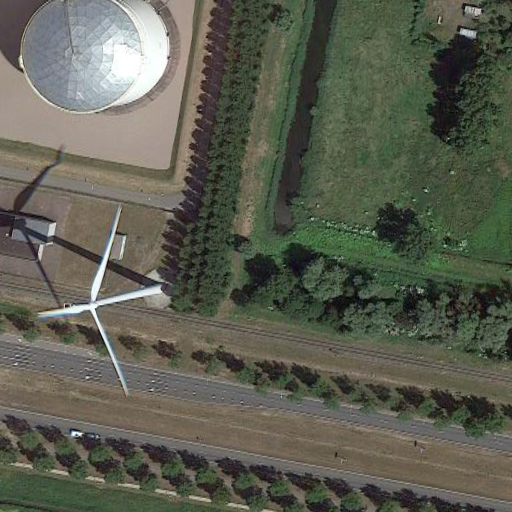

In [28]:
# Function to find top-k similar images
def find_top_k_similar(image_path, description, processor, data, k=5):
    # Get the embedding for the new image and description
    query_embedding = get_combined_embedding(image_path, description, processor)
    
    # Stack embeddings and calculate similarities
    embeddings = np.stack(data['embedding'].values)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    
    # Find top-k indices
    top_k_indices = similarities.argsort()[-k:][::-1]
    top_k_images = data.iloc[top_k_indices]
    
    return top_k_images[['image_path', 'generated_text', 'embedding']]

# Example usage:
# image_path = "E:/datasets/DOTA_dataset_512/train/images/P0011_7.png"
# description = "A photo of red, orange, white, gray, and black trucks and cars in a parking lot"
# image_path = "E:/datasets/DOTA_dataset_512/train/images/P0020_34.png"
# description = "A photo of yellow parked car near trees, water and a dock"
# image_path = "E:/datasets/DOTA_dataset_512/train/images/P2641_87.png"
# description = "A photo of a orange container ship"
image_path = "E:/datasets/DOTA_dataset_512/train/images/P2644_87.png"
description = "A photo of a wind turbine near trees"
description = "A photo of a storage tank near trees"
top_k_images = find_top_k_similar(image_path, description, processor, context_df, k=10)
img = Image.open(image_path)
display(img)

Processing images:   0%|          | 0/7750 [00:00<?, ?it/s]

E:/datasets/DOTA_dataset_512/val/images/P2701_11.png
an aerial view of oil tanks in the middle of a field



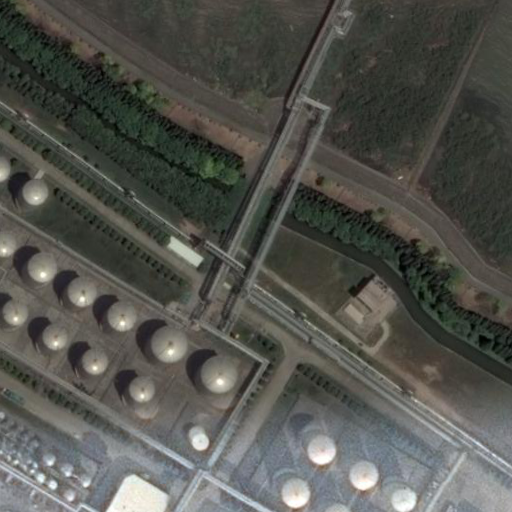

E:/datasets/DOTA_dataset_512/val/images/P2709_10.png
an aerial view of oil tanks on the side of a road



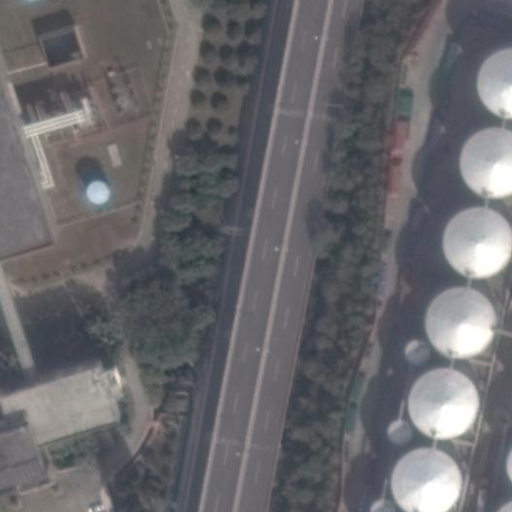

Processing images:   0%|          | 2/7750 [00:00<10:50, 11.92it/s]

E:/datasets/DOTA_dataset_512/val/images/P2745_45.png
an aerial view of two oil tanks in the middle of a forest



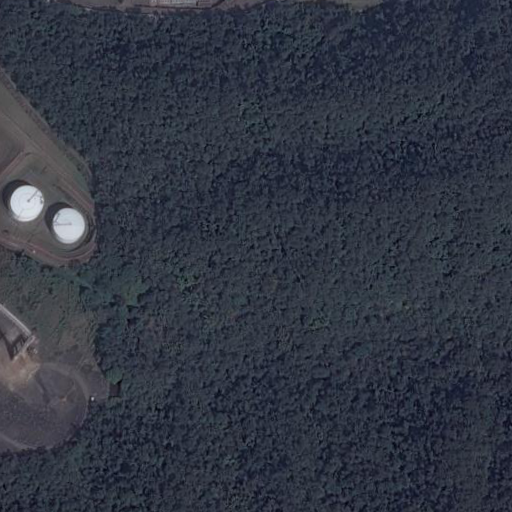

E:/datasets/DOTA_dataset_512/val/images/P2709_36.png
an aerial view of oil tanks in the middle of a city



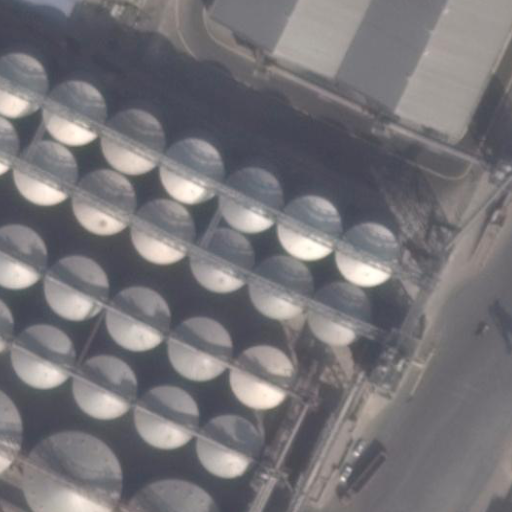

Processing images:   0%|          | 4/7750 [00:00<10:14, 12.61it/s]

E:/datasets/DOTA_dataset_512/val/images/P2745_35.png
an aerial view of an oil tank farm in the middle of a wooded area



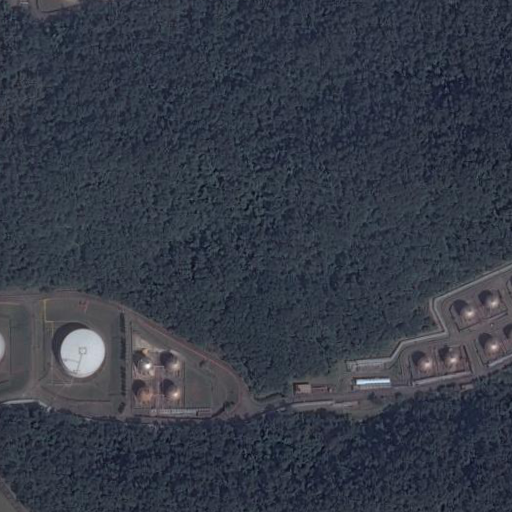

E:/datasets/DOTA_dataset_512/val/images/P2645_69.png
an aerial view of oil tanks in an industrial area



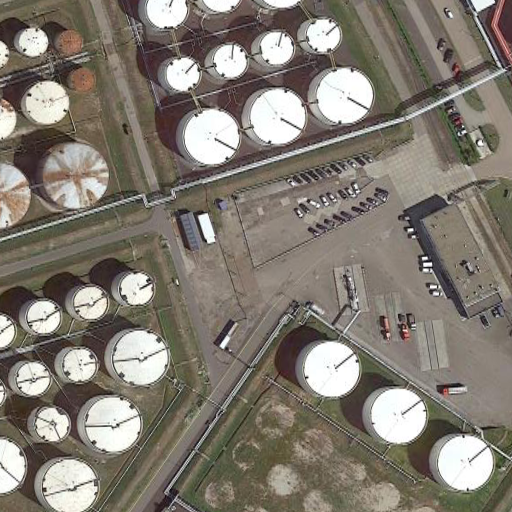

Processing images:   0%|          | 6/7750 [00:00<09:56, 12.98it/s]

E:/datasets/DOTA_dataset_512/val/images/P2645_54.png
an aerial view of oil tanks in the water



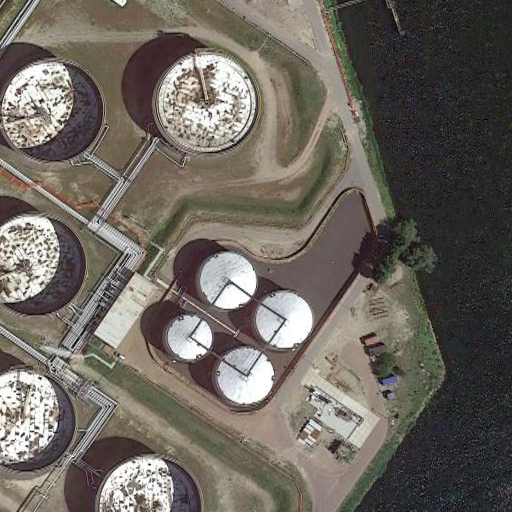

E:/datasets/DOTA_dataset_512/val/images/P2745_34.png
an aerial view of several oil tanks in the middle of a forest



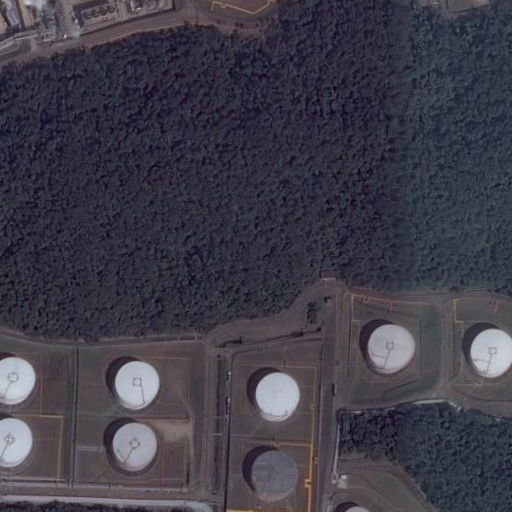

Processing images:   0%|          | 8/7750 [00:00<10:05, 12.79it/s]

E:/datasets/DOTA_dataset_512/val/images/P2645_68.png
an aerial view of oil tanks in the water



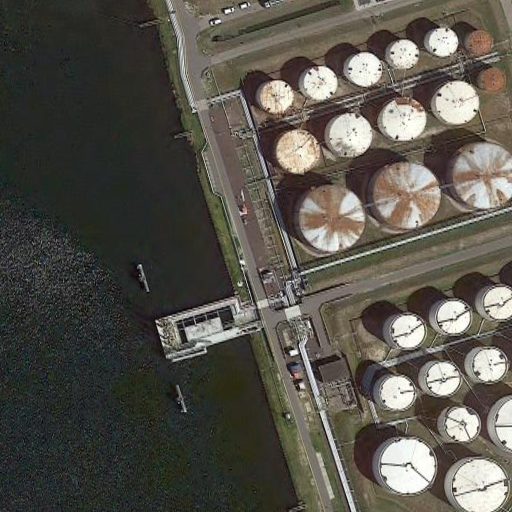

E:/datasets/DOTA_dataset_512/val/images/P2645_77.png
an aerial view of oil tanks in a large industrial area



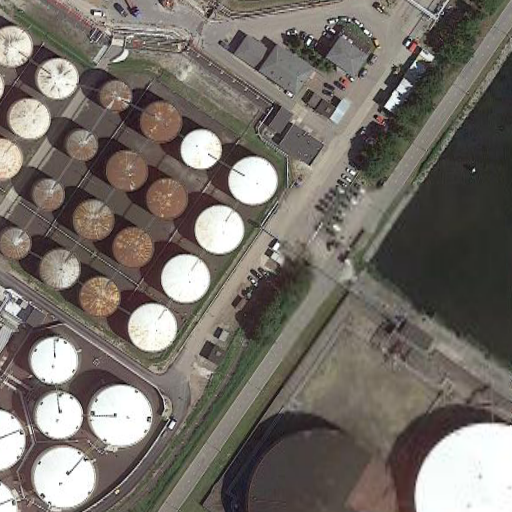

Processing images:   0%|          | 10/7750 [00:00<09:59, 12.90it/s]


In [29]:
for idx, row in tqdm(top_k_images.iterrows(), total=len(context_df), desc="Processing images"):
    print(f'{row.image_path}\n{row.generated_text}\n')
    img = Image.open(row.image_path)
    display(img)